In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
from astropy.table import Table
import sys
sys.path.append("../")
import read_mist_models
from matplotlib import colors
from scipy.interpolate import interp1d
import utils
from astropy.coordinates import SkyCoord
from astropy import units as u
import gyrochrones as gyr

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', handlelength=10)
pl.rc('legend', fontsize=20)
pl.rc('image', cmap='Spectral_r')

%matplotlib inline

#### Load in output from round.py and crossmatch with k2dr2 table from Bailer-Jones et al

In [2]:
data = utils.read_round("../output/out.dat")
k2dr2 = Table.read('../k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic_number')
df = df.drop_duplicates(subset='epic_number')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# correct for gp catching twice the period 
tofix = np.abs(np.exp(df['logperiod_mean']) - 2*df['acfpeak']) < 0.1
df[tofix] = df[tofix].replace(df['logperiod_mean'], 2*df['logperiod_mean'], inplace=True)

#### Read in mist isochrone (for picking main sequence) and parsec isochrones (for converting from gaia mags to Johnson mags)

In [4]:
iso = read_mist_models.ISOCMD('../MIST_iso_5da0dbfba0a60.iso.cmd')
mist = iso.isocmds[iso.age_index(9.0)]
isonames1 = ('Zini','Age','Mini','Mass','logL','logTe','logg','label','McoreTP',
            'C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo',
            'Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag','B_Tmag','V_Tmag',
            'Jmag','Hmag','Ksmag')
parsec1 = pd.read_table('../parsec/output783328222883.dat', delim_whitespace=True, header=None, comment='#', names=isonames1)
isonames2 = ('Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 
             'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 
             'Xo', 'Cexcess', 'Z', 'mbolmag', 'Umag', 'Bmag', 'Vmag', 'Rmag', 'Imag', 'Jmag', 'Hmag', 'Kmag')
parsec2 = pd.read_table('../parsec/output632510793236.dat', delim_whitespace=True, header=None, comment='#', names=isonames2)
iok = np.where((parsec1['label'] < 2) & (parsec1['Gmag'] > 1.7))[0][::-1]

Reading in: ../MIST_iso_5da0dbfba0a60.iso.cmd


In [59]:
print(len(df))

293396


#### Select stars with good gaia solutions

In [5]:
# select stars with good gaia results 

good_parallax = df["parallax_error"] < 0.1
unimodal_distance_result = (df["r_modality_flag"] == 1) & (df["r_result_flag"] == 1)
has_finite_bp_rp = np.isfinite(df["bp_rp"])
good_bp = df["phot_bp_mean_flux_error"]/df[u'phot_bp_mean_flux'] < 0.01
good_rp = df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01
good_mg = df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01
in_r_range = (df["r_est"] > 0) & (df["r_est"] < 600)
mask = good_parallax & unimodal_distance_result & has_finite_bp_rp & good_bp & good_rp & good_mg & in_r_range

#### Interpolate from Gaia GP-RP color to Johnson B-V color

In [6]:
iso_bp_rp = mist['Gaia_BP_MAWb'] - mist['Gaia_RP_MAW']
iso_mg = mist['Gaia_G_MAW']
mass_mask = (mist['initial_mass'] < 2.0) & (mist['initial_mass'] > 0.2)
iso_bp_rp = iso_bp_rp[mass_mask]
iso_mg = iso_mg[mass_mask]

in_color_range = (df["bp_rp"] > min(iso_bp_rp)) & (df["bp_rp"] < max(iso_bp_rp))
mask = mask & in_color_range

interpolator = interp1d(iso_bp_rp, iso_mg)
iso_mg_interp = interpolator(df[mask]['bp_rp'])

#### Select main sequence

/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0


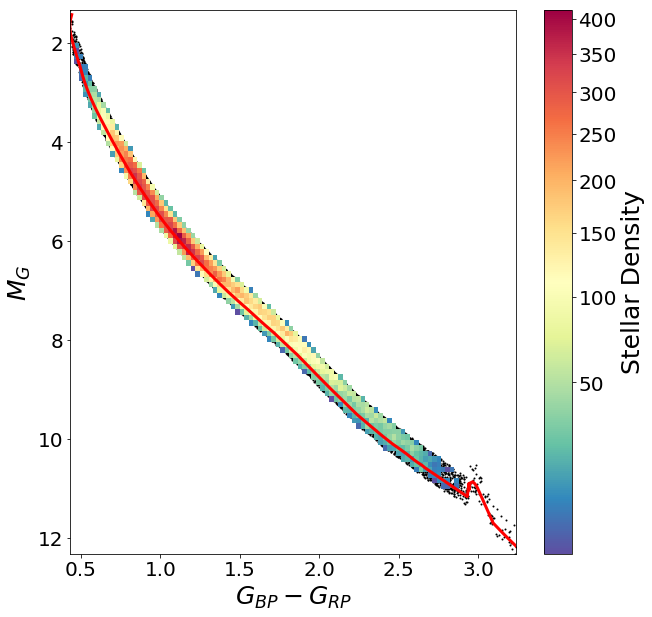

54454


In [7]:
correction = 5*np.log10(df[mask]["r_est"])-5 # get absolute mag Mg from relative mg by applying distance correction 
bp_rp, mg = np.array(df[mask]["bp_rp"]), np.array(df[mask]["phot_g_mean_mag"])-correction
is_ms = (mg - iso_mg_interp < 0.2) & (iso_mg_interp - mg < 0.4)

fig, ax = pl.subplots(figsize=(10, 10))

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(bp_rp[is_ms], mg[is_ms], bins=100, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)

# fill the rest with scatter
ax.scatter(bp_rp[is_ms], mg[is_ms], alpha=1, s=1, color='k', zorder=0)
ax.plot(iso_bp_rp, iso_mg, 'r', linewidth=3) 
ax.invert_yaxis()
cb = fig.colorbar(h[3])
ax.set_xlabel('$G_{BP} - G_{RP}$')
ax.set_ylabel('$M_G$')
cb.set_label("Stellar Density")
pl.show()
print(sum(is_ms))

#### Plot period vs. Gaia color

In [8]:
relative_uncertainty = df['logperiod_sd']/df['logperiod_mean']
snr = df['logamp_mean']-df['logs2_mean']
nobeehive = (df['k2_campaign_str'] != b'5') & (df['k2_campaign_str'] != b'16')
#good_period = ((df['logperiod_neff'] > 6500) & 
#               (np.abs(np.exp(df['logperiod_mean']) - df['acfpeak']) < 1) & 
#               (relative_uncertainty < 10) & (np.exp(df['logperiod_mean']) < 32) &
#               (snr > np.log(10)))
good_period = ((np.abs(df['logperiod_rhat'] - 1.0) < 0.01) & 
               (np.abs(np.exp(df['logperiod_mean']) - df['acfpeak']) < 1) &
               (df['logperiod_neff'] > 7000) & 
               (df['logperiod_mean'] < np.log(30)))

df_good = df[mask & is_ms & good_period]

period = np.exp(df_good['logperiod_mean'])
logperiod_error = df_good['logperiod_sd']
logperiod = df_good['logperiod_mean']
color = df_good['bp_rp']
print(len(df_good))

3976


#### Convert Gaia colors to B-V 

In [9]:
period = np.exp(df_good['logperiod_mean'])
BV_ms = np.interp(df_good['bp_rp'], parsec1['G_BPmag'][iok] - parsec1['G_RPmag'][iok],
                 parsec2['Bmag'][iok] - parsec2['Vmag'][iok])
df_good['B_V'] = BV_ms

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


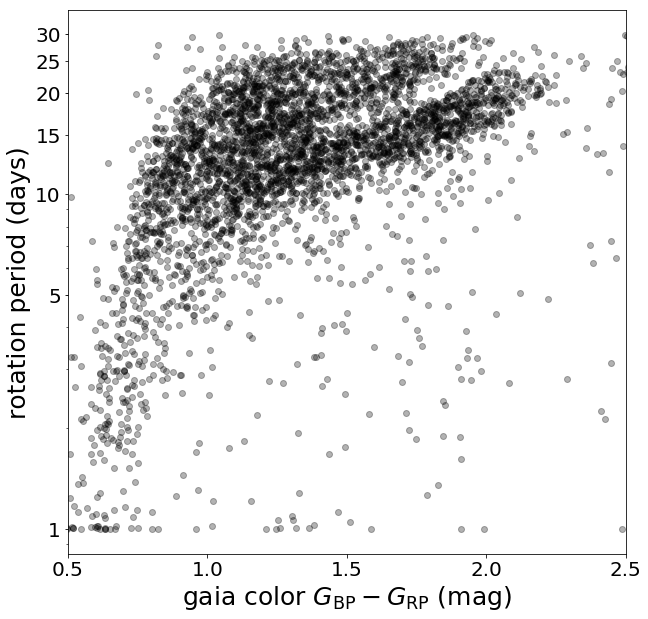

In [10]:
fig = pl.figure(figsize=(10, 10))
pl.semilogy(df_good['bp_rp'], period, 'o', alpha=0.3, color='k')
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30])
pl.gca().set_xticks(np.linspace(0.5, 2.5, 5))
pl.xlabel("gaia color $G_\mathrm{BP} - G_\mathrm{RP}$ (mag)")
pl.ylabel("rotation period (days)")
pl.xlim(0.5, 2.5)
pl.savefig("/Users/tgordon/Desktop/period_color.pdf")

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


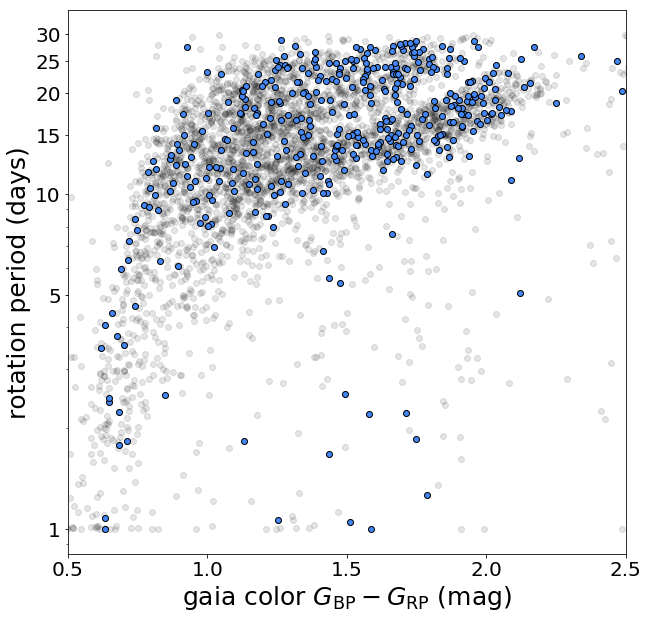

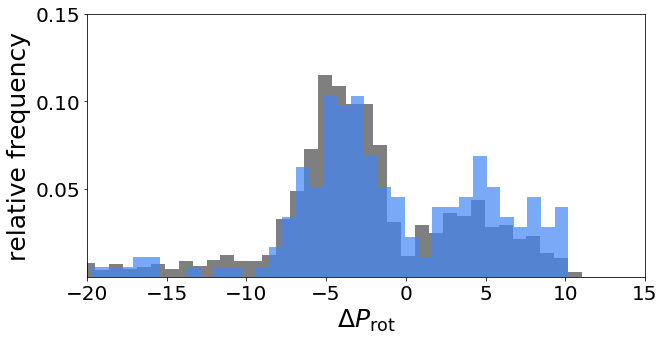

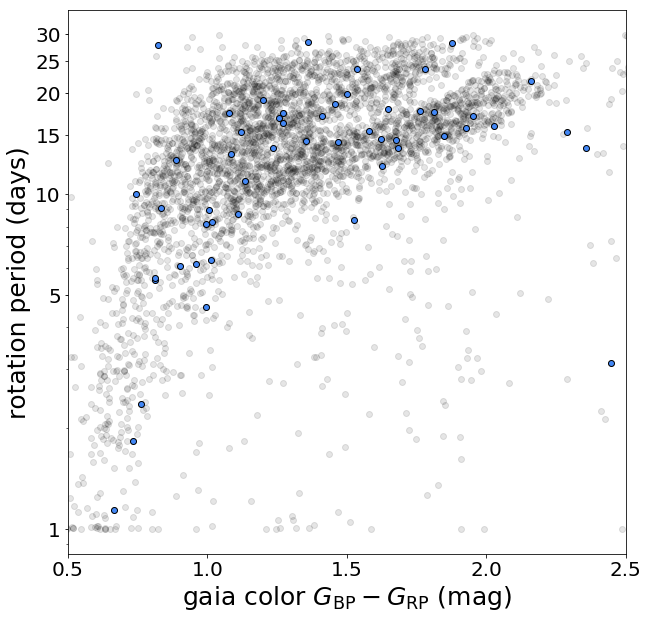

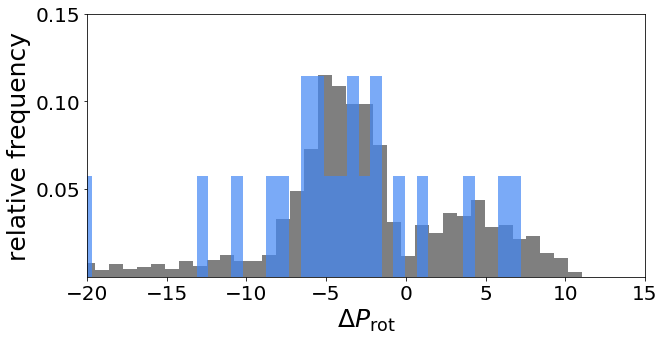

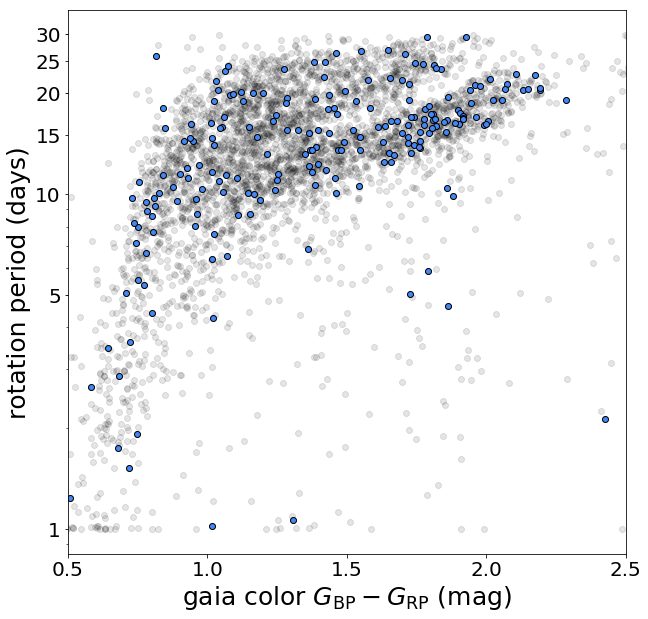

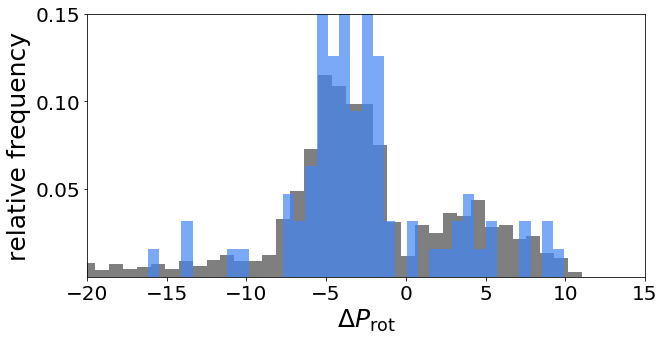

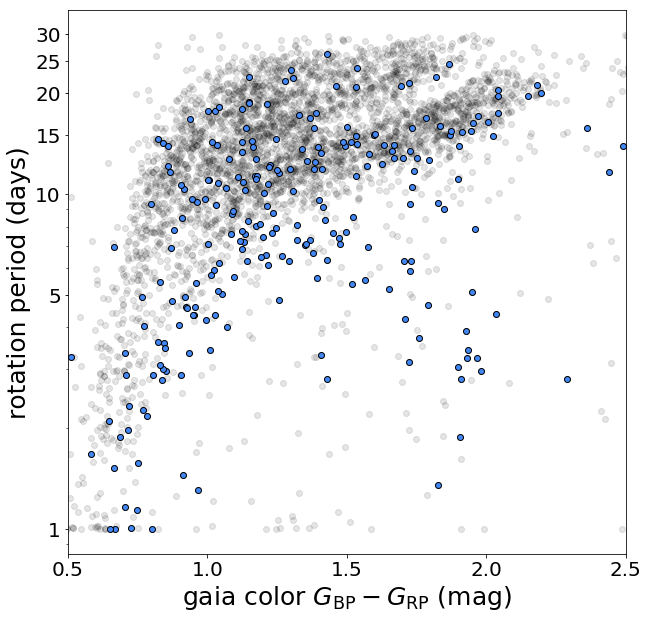

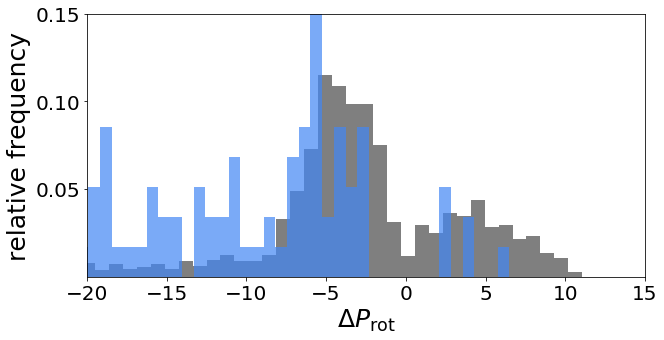

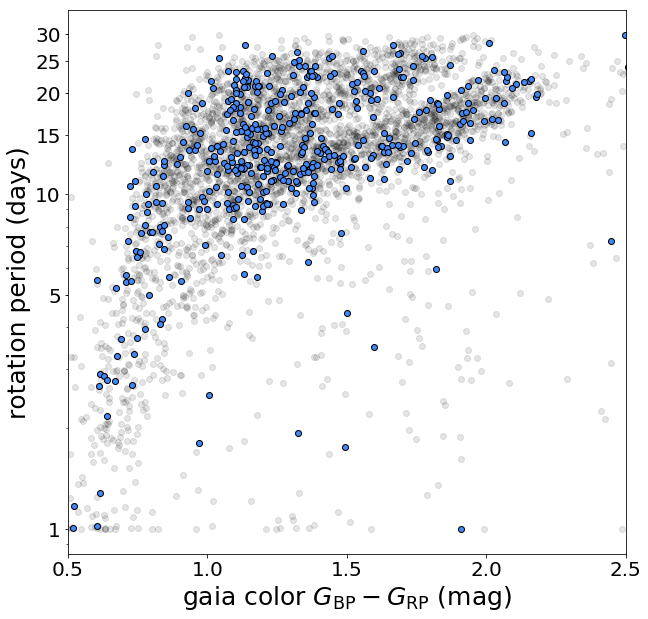

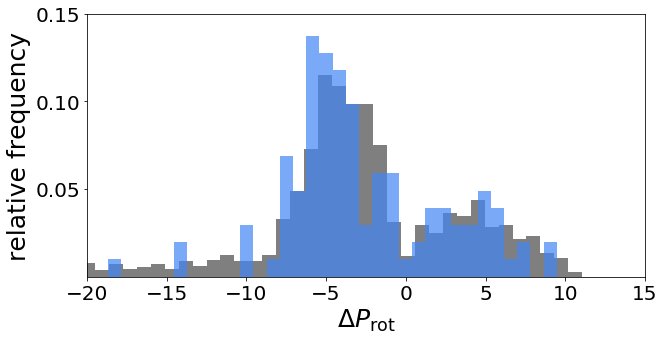

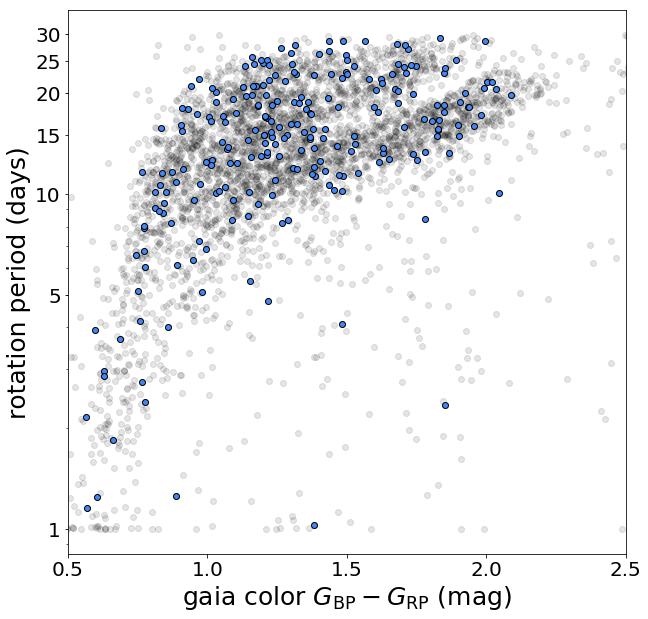

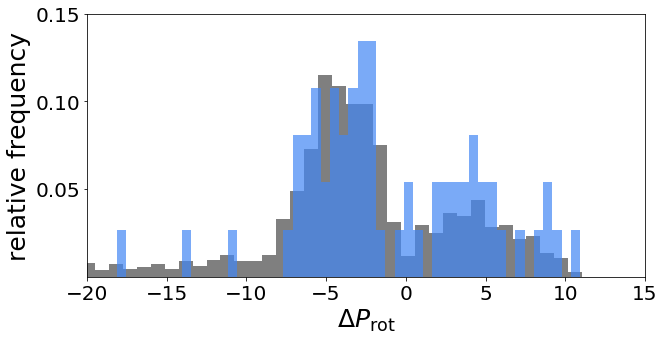

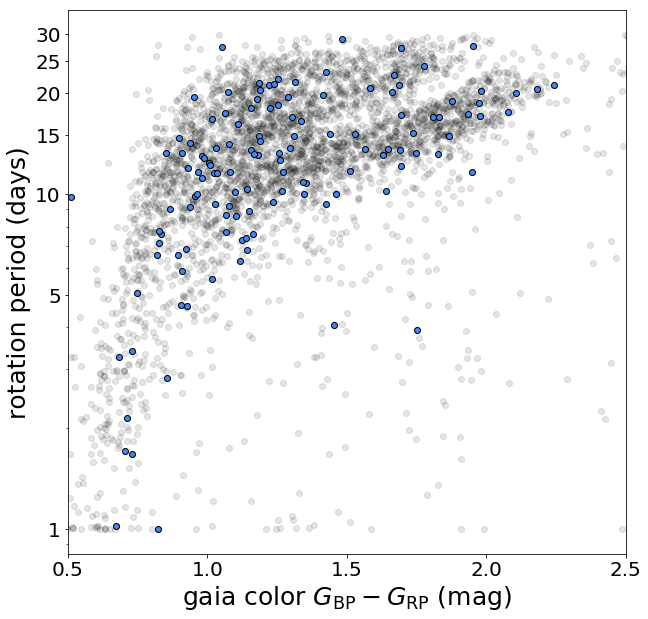

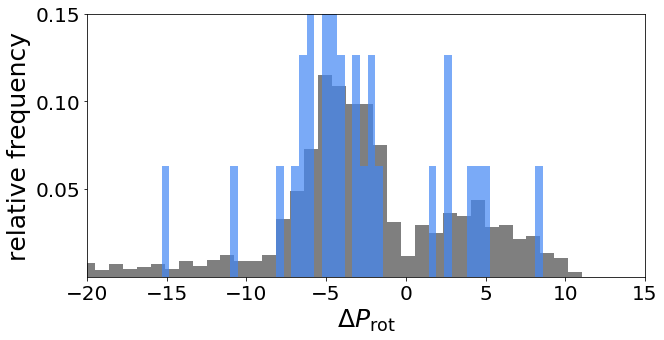

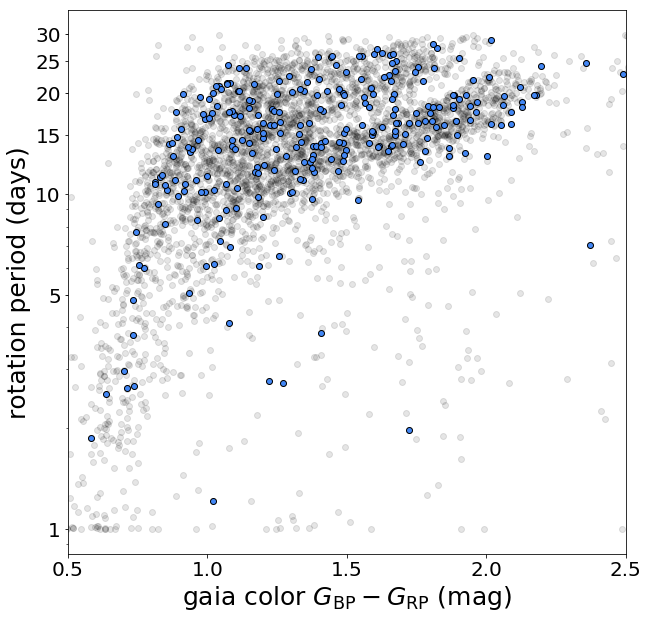

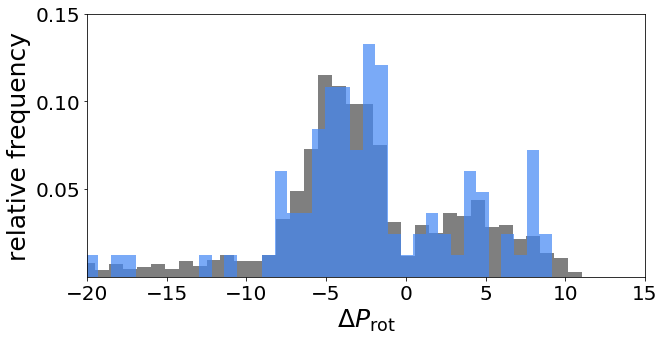

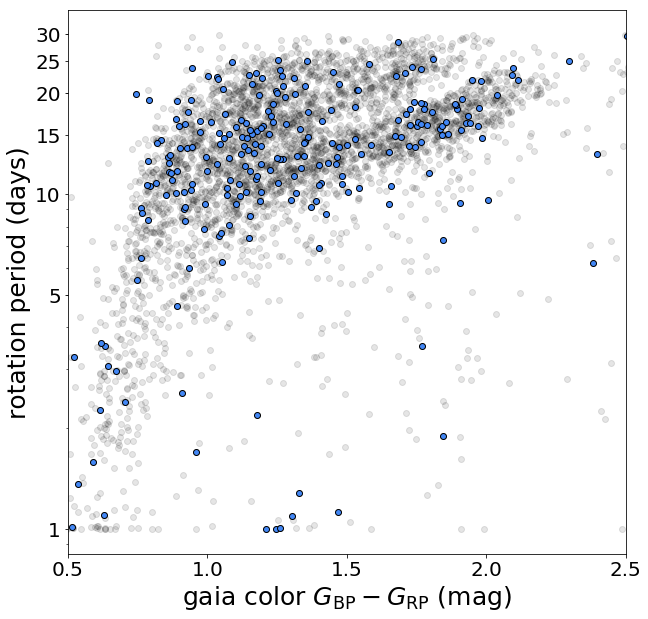

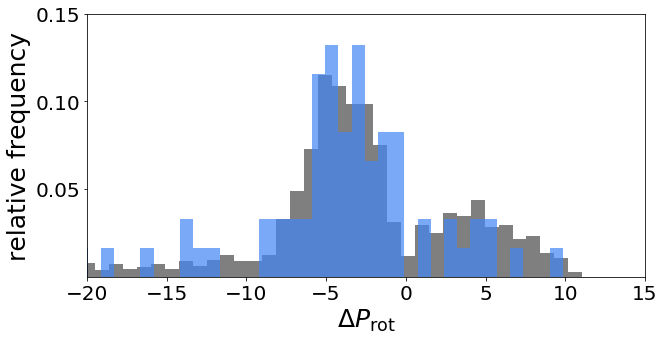

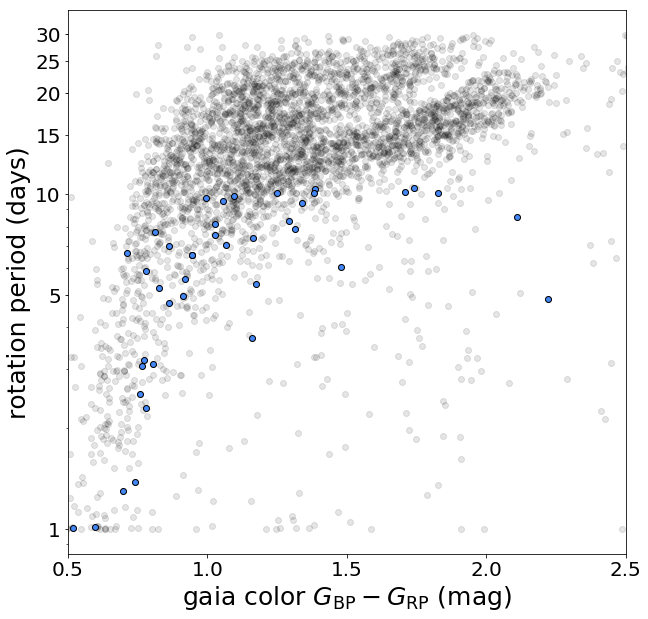

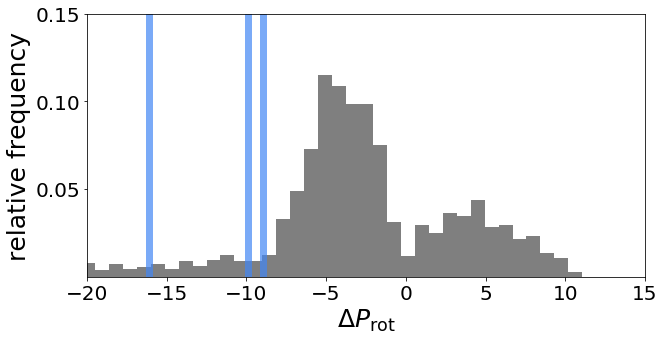

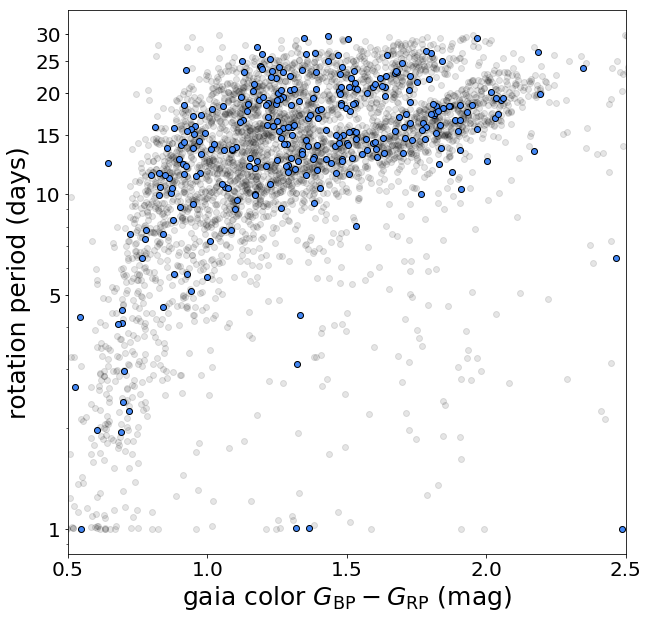

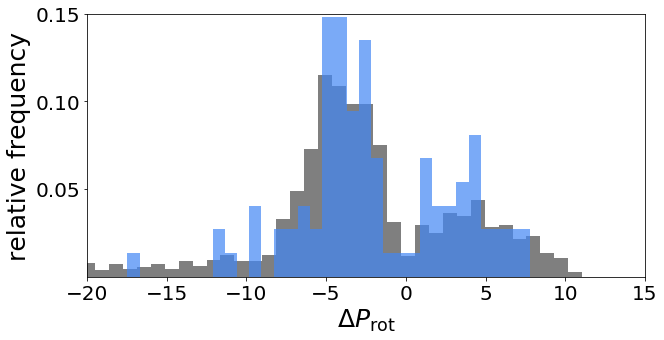

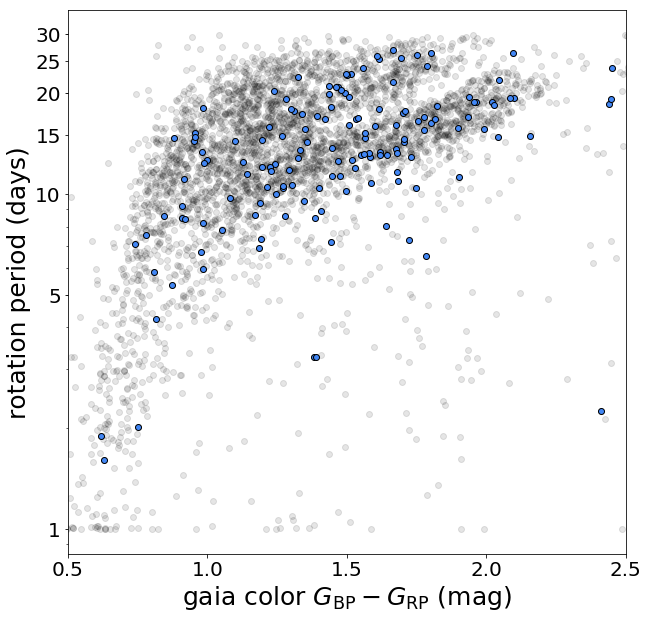

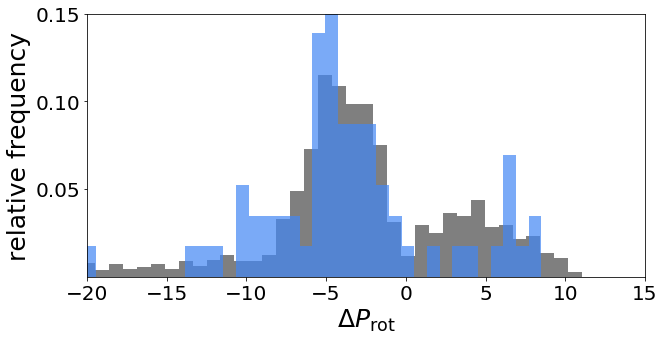

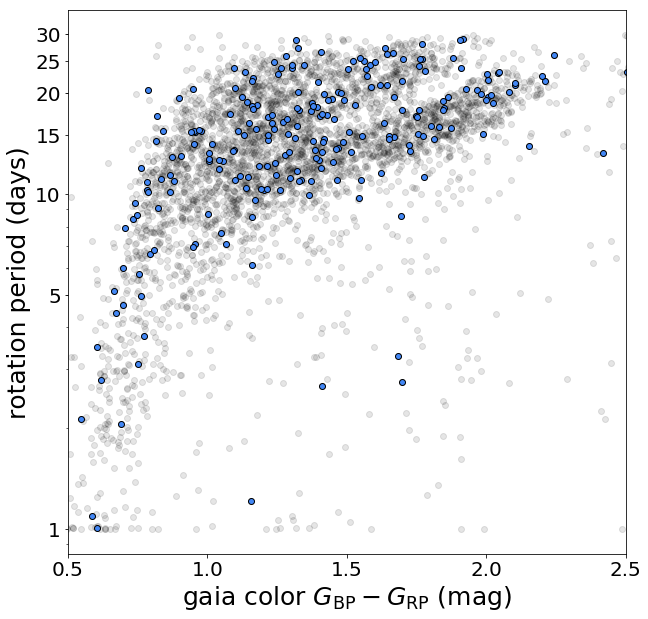

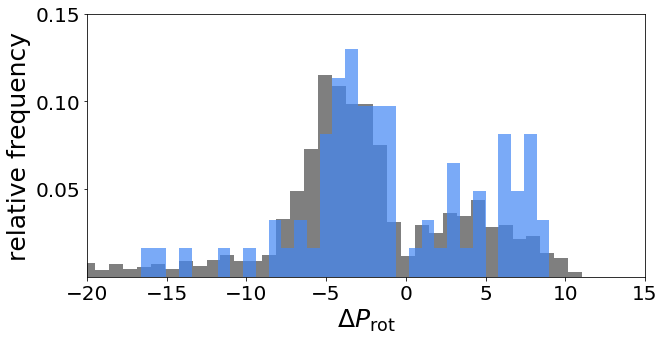

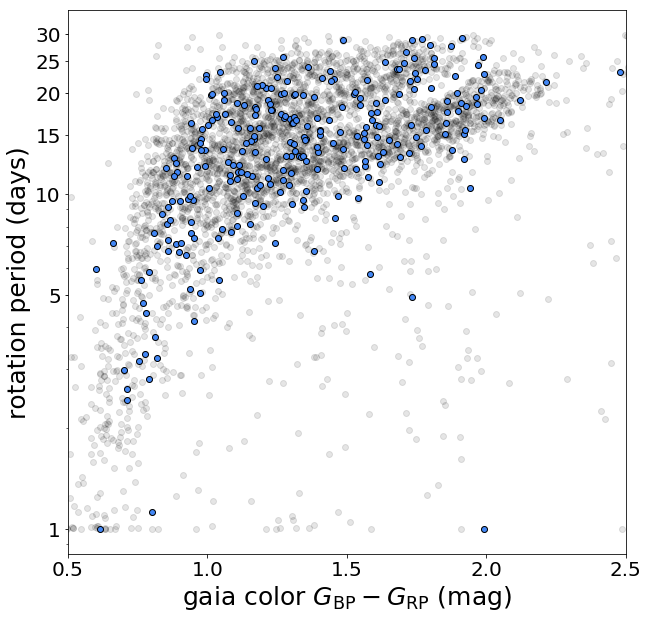

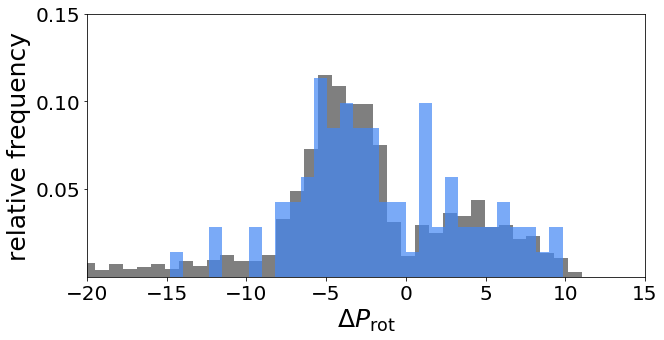

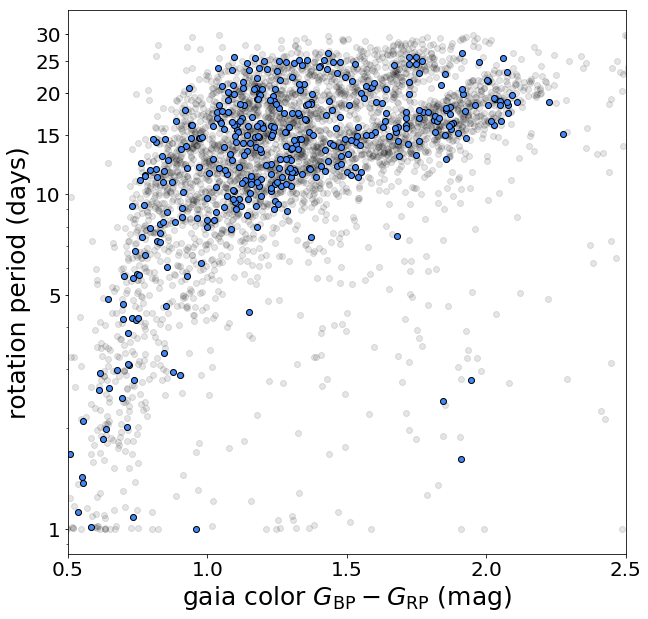

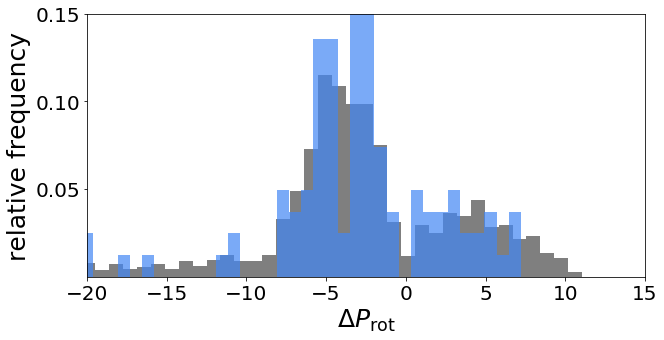

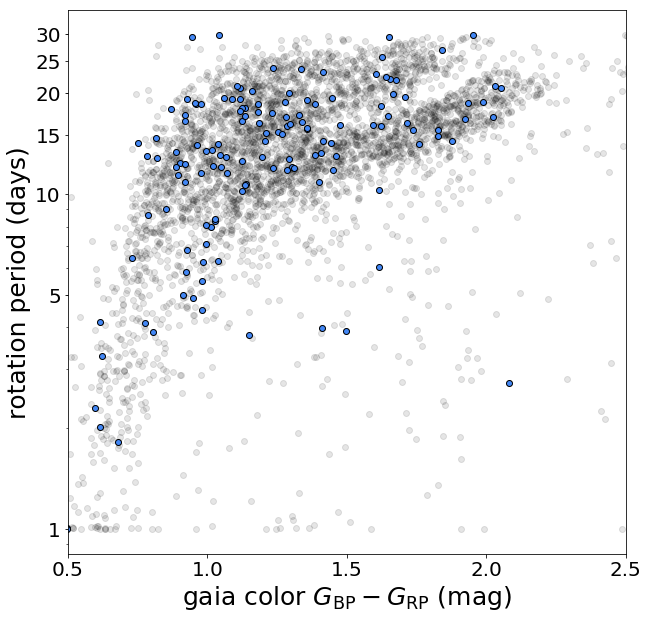

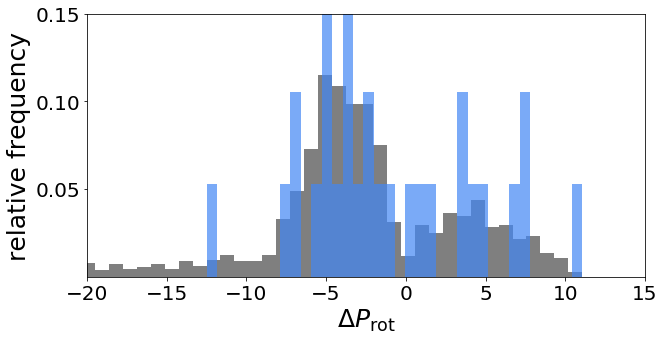

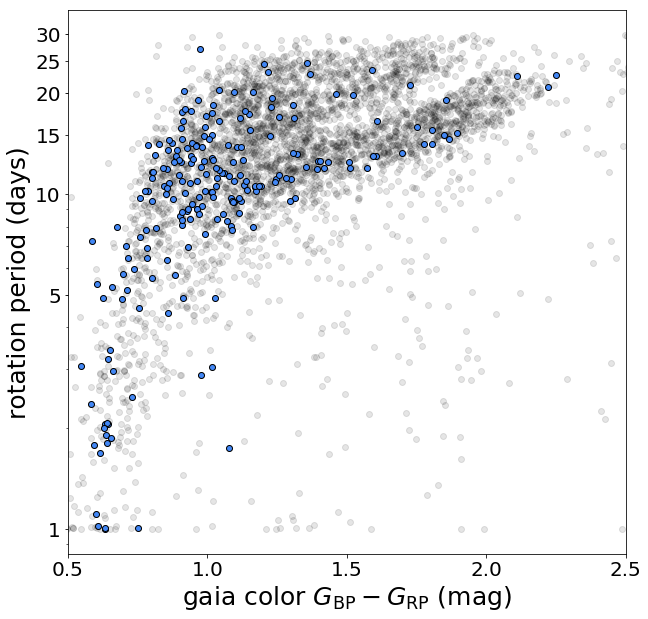

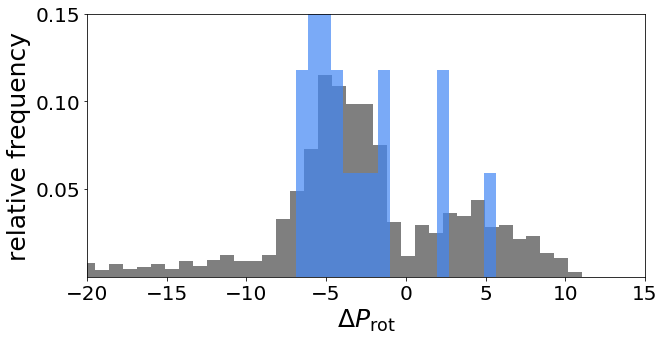

In [40]:
highlight_color = np.array((66, 135, 245))/255
BV_mask = (BV_ms > 1.2) & (BV_ms < 3.0)
for campaign in [b'1', b'2', b'3', b'4', b'5', b'6', b'7',
                 b'8', b'10', b'11', b'12', b'13', b'14', 
                 b'15', b'16', b'17', b'18']:
    fig = pl.figure(figsize=(10, 10))
    pl.semilogy(df_good['bp_rp'], period, 'o', alpha=0.1, color='k')
    campaign_mask = (df_good['k2_campaign_str'] == campaign)
    pl.semilogy(df_good['bp_rp'][campaign_mask], period[campaign_mask], 'o', alpha=1, 
                color=highlight_color, markeredgecolor='k')
    pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
    pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30])
    pl.gca().set_xticks(np.linspace(0.5, 2.5, 5))
    pl.xlabel("gaia color $G_\mathrm{BP} - G_\mathrm{RP}$ (mag)")
    pl.ylabel("rotation period (days)")
    pl.xlim(0.5, 2.5)
    pl.savefig("/Users/tgordon/Desktop/period_color_by_campaign/period_color_campaign{0}.pdf".format(campaign))
    
    pl.figure(figsize=(10, 5))
    pl.hist(period[BV_mask] - gyr.Gordon2019(BV_ms[BV_mask]), bins=50, density=True, color='k', alpha=0.5);
    pl.hist(period[BV_mask & campaign_mask] - gyr.Gordon2019(BV_ms[BV_mask & campaign_mask]), 
            bins=50, color=highlight_color, density=True, alpha=0.7);
    pl.ylim(0, 0.15)
    pl.xlim(-20, 15)
    pl.gcf().subplots_adjust(bottom=0.15)
    pl.gca().set_yticks([0.05, 0.10, 0.15])
    pl.xlabel("$\Delta P_\mathrm{rot}$")
    pl.ylabel("relative frequency")
    pl.savefig("/Users/tgordon/Desktop/period_color_by_campaign/hist{0}.pdf".format(campaign))

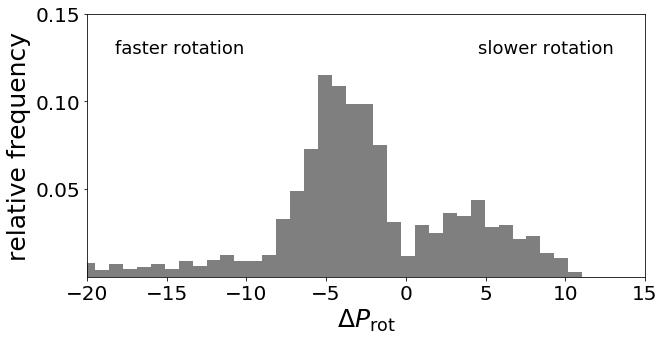

In [84]:
pl.figure(figsize=(10, 5))
pl.hist(period[BV_mask] - gyr.Gordon2019(BV_ms[BV_mask]), bins=50, density=True, color='k', alpha=0.5);
#pl.hist(period[BV_mask & campaign_mask] - 13*BV_ms[BV_mask & campaign_mask]**1.73, 
#        bins=50, color=highlight_color, density=True, alpha=0.7);
#pl.axvline(0, color='k', linewidth=3)
#pl.axvspan(-20, 0, color='b', alpha=0.2)
#pl.axvspan(0, 15, color='r', alpha=0.2)
pl.annotate("faster rotation", xy=(0.05, 0.85), xycoords="axes fraction", fontsize=18)
pl.annotate("slower rotation", xy=(0.7, 0.85), xycoords="axes fraction", fontsize=18)
pl.ylim(0, 0.15)
pl.xlim(-20, 15)
pl.gcf().subplots_adjust(bottom=0.15)
pl.gca().set_yticks([0.05, 0.10, 0.15])
pl.xlabel("$\Delta P_\mathrm{rot}$")
pl.ylabel("relative frequency")
pl.savefig("/Users/tgordon/Desktop/hist.pdf")

#### Fine a good isochrone for separating modalities

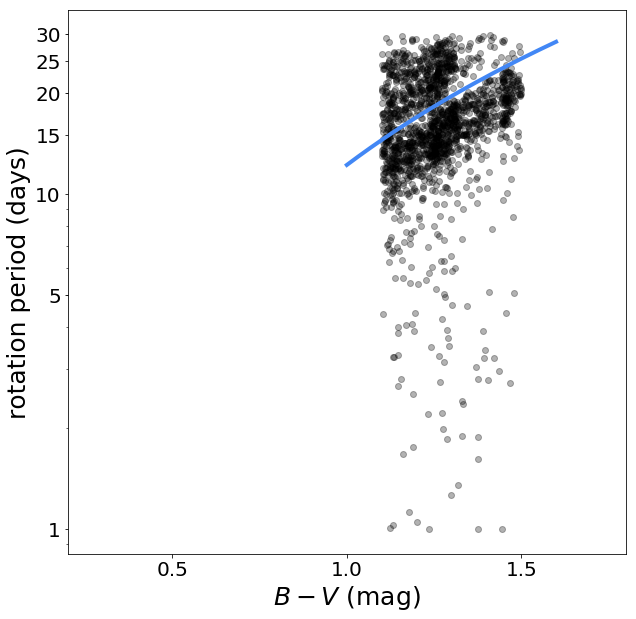

In [26]:
highlight_color = np.array((66, 135, 245))/255
fig = pl.figure(figsize=(10, 10))
lims = 1.1, 1.5
BV_mask = (BV_ms > lims[0]) & (BV_ms < lims[1])
pl.semilogy(BV_ms[BV_mask], period[BV_mask], 'o', alpha=0.3, color='k')
#pl.semilogy(BV_ms, gyr.MM09e3(BV_ms, 500), '.')
#pl.semilogy(BV_ms,  12.5*BV_ms**1.75, '.')
xbv = np.linspace(1.0, 1.6, 1000)
pl.semilogy(xbv, gyr.Gordon2019(xbv), linewidth=4, color=highlight_color)
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30])
pl.gca().set_xticks(np.linspace(0.5, 2.5, 5))
pl.xlabel("$B - V$ (mag)")
pl.ylabel("rotation period (days)")
pl.xlim(0.2, 1.8)
pl.savefig("/Users/tgordon/Desktop/period_color_gyr.pdf")

#### Plot histogram of rotation periods relative to gyrochrone

In [ ]:
BV_mask = (BV_ms > 1.2) & (BV_ms < 3.0)
pl.figure(figsize=(10, 5))
pl.hist(period[BV_mask] - 13*BV_ms[BV_mask]**1.73, bins=50, color='k', alpha=0.7);
pl.xlim(-20, 15)
#pl.plot(BV_ms[BV_mask], period[BV_mask] - 13*BV_ms[BV_mask]**1.6, '.')

#### Use Gaia to find galactocentric coordinates

In [ ]:
ra, dec, dist = list(df_good['ra']), list(df_good['dec']), list(df_good['r_est'])
coords = [SkyCoord(ra = ra[i]*u.degree, dec = dec[i]*u.degree, distance = dist[i]*u.parsec) for i in range(len(ra))]
df_good['galcen_x'] = [c.galactocentric.x.value for c in coords]
df_good['galcen_y'] = [c.galactocentric.y.value for c in coords]
df_good['galcen_z'] = [c.galactocentric.z.value for c in coords]

#### Plot stars in galactocentric coordinates

In [ ]:
pl.figure(figsize=(10, 10))
pl.plot(df_good['galcen_x'][df_good['galcen_y'] > 0], df_good['galcen_y'][df_good['galcen_y'] > 0], 'r.')
pl.plot(df_good['galcen_x'][df_good['galcen_y'] < 0], df_good['galcen_y'][df_good['galcen_y'] < 0], 'b.')
pl.xlabel("galactocentric x")
pl.ylabel("galactocentric y")
pl.savefig("../figures/position.pdf")

### Save selected stars to an hdf5 file 

In [ ]:
df_good.to_hdf('../output/good.h5', key='df', mode='w')
print(len(df_good))

In [ ]:
pl.figure(figsize=(10, 10))
pl.scatter(df_good['galcen_x'], df_good['galcen_y'], c=df_good['k2_campaign_str'])
cb = pl.colorbar()
#pl.plot(df_good['galcen_x'][df_good['galcen_y'] < 0], df_good['galcen_y'][df_good['galcen_y'] < 0], 'b.')
pl.xlabel("galactocentric x")
pl.ylabel("galactocentric y")
#pl.savefig("../figures/position.pdf")

In [ ]:
pl.figure(figsize=(10, 10))
pl.scatter(df_good['galcen_x'][df_good['k2_campaign_str'] != b'17'], df_good['galcen_y'][df_good['k2_campaign_str'] != b'17'], c=df_good['k2_campaign_str'][df_good['k2_campaign_str'] != b'17'])
cb = pl.colorbar()
#pl.plot(df_good['galcen_x'][df_good['galcen_y'] < 0], df_good['galcen_y'][df_good['galcen_y'] < 0], 'b.')
pl.xlabel("galactocentric x")
pl.ylabel("galactocentric y")
#pl.savefig("../figures/position.pdf")